# Sunset classification using fast.ai library
i this notebook i implcate the fast.ai 1 and 6 lesson. i create a classification between sunsen in 3 place in the word, and used heat map to see what the model were learned.

In [2]:
from fastai.vision import *

### Download into file

i download the data using the fast.ai first notebook. you can see all the credit there.

In [3]:
data_place = {"telaviv": "sunset_telaviv.txt", "rio": "sunset_rio.txt", "london": "sunset_london.txt"}

In [17]:
for folder, file in data_place.items():
    path = Path('data/sunset')
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    download_images(path/file, dest, max_pics=200)

In [20]:
classes = data_place.keys()

In [21]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

telaviv


cannot identify image file <_io.BufferedReader name='data/sunset/telaviv/00000022.jpg'>
cannot identify image file <_io.BufferedReader name='data/sunset/telaviv/00000111.jpg'>
cannot identify image file <_io.BufferedReader name='data/sunset/telaviv/00000032.jpg'>
rio


cannot identify image file <_io.BufferedReader name='data/sunset/rio/00000143.jpg'>
cannot identify image file <_io.BufferedReader name='data/sunset/rio/00000040.jpg'>
cannot identify image file <_io.BufferedReader name='data/sunset/rio/00000080.png'>
cannot identify image file <_io.BufferedReader name='data/sunset/rio/00000116.jpg'>
cannot identify image file <_io.BufferedReader name='data/sunset/rio/00000089.png'>
cannot identify image file <_io.BufferedReader name='data/sunset/rio/00000025.png'>
cannot identify image file <_io.BufferedReader name='data/sunset/rio/00000074.png'>
cannot identify image file <_io.BufferedReader name='data/sunset/rio/00000059.jpg'>
london


Image data/sunset/london/00000050.png has 4 instead of 3 channels
cannot identify image file <_io.BufferedReader name='data/sunset/london/00000039.jpg'>
cannot identify image file <_io.BufferedReader name='data/sunset/london/00000073.jpg'>
cannot identify image file <_io.BufferedReader name='data/sunset/london/00000027.jpg'>


## View data

In [3]:
np.random.seed(42)
path = Path('data/sunset')
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [4]:
data.classes

['london', 'rio', 'telaviv']

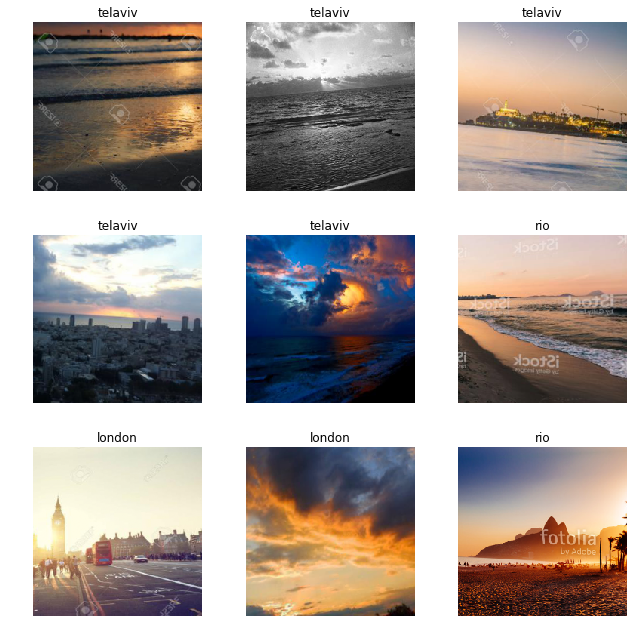

In [5]:
data.show_batch(rows=3, figsize=(9,9))

In [6]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['london', 'rio', 'telaviv'], 3, 381, 95)

## Train model

In [7]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [29]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.334201,0.829460,0.389474
2,1.041773,0.528862,0.200000
3,0.846677,0.492666,0.178947
4,0.725111,0.484423,0.168421


In [30]:
learn.save('stage-1')

In [58]:
learn.unfreeze()
learn.lr_find()

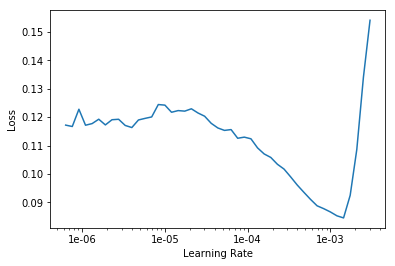

In [60]:
learn.recorder.plot()

In [73]:
learn.fit_one_cycle(5, max_lr=slice(3e-6,3e-4))

epoch,train_loss,valid_loss,error_rate
1,0.035263,0.198603,0.084211
2,0.033018,0.200118,0.084211
3,0.027070,0.196127,0.084211
4,0.024925,0.192470,0.084211
5,0.022292,0.195516,0.073684


In [76]:
learn.save('stage-3')

## Interpretation

In [8]:
learn.load('stage-3');

In [9]:
interp = ClassificationInterpretation.from_learner(learn)

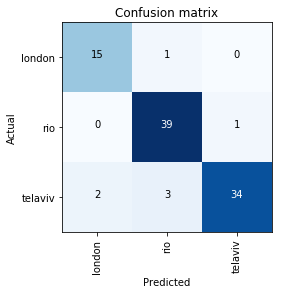

In [10]:
interp.plot_confusion_matrix()

## heatmap
i create a simple class to simple process of the model.

In [11]:
from fastai.callbacks.hooks import *

In [12]:
m = learn.model.eval();

In [13]:
class HeatMap():
    def __init__(self, model, new_data, num = 9):
        self.model = model
        self.data = new_data
        self.num = num
        self.x,self.y, self.hook_a_proc, self.hook_g_proc = [[] for i in range(4)]
        self.export_images()
        
    def export_images(self):
        l = np.random.randint(95, size=(self.num))
        self.x = [self.data.valid_ds[idx][0] for idx in l]
        self.y = [self.data.valid_ds[idx][1] for idx in l]
        xb = [self.data.one_item(x)[0] for x in self.x]
        self.xb_im = [Image(self.data.denorm(x)[0]) for x in xb]
        self.xb = [x.cuda() for x in xb]
    
    def show_images(self, heat=False, grad=False):
        hm = self.hook_a_proc if not grad else self.hook_g_proc
        rows = int(np.ceil(math.sqrt(len(self.xb_im)))) if self.num !=3 else 3
        rows1 = row if self.num !=3 else 1
        axs = subplots(rows1, rows, imgsize=(224,224), figsize=(12,12))
        for i,x,y,ax in zip(range(len(self.xb_im)),self.xb_im, self.y, axs.flatten()):
            x.show(ax=ax, y=y)
            if heat:
                ax.imshow(hm[i], alpha=0.6, extent=(0,224,224,0),
                    interpolation='bilinear', cmap='magma');
            
    def hooked_backward(self, level=-1):
        self.hook_a, self.hook_g = [], []
        for i, x in enumerate(self.xb):
            with hook_output(self.model[0][level]) as hook_a:
                with hook_output(self.model[0][level], grad=True) as hook_grad:
                    preds = self.model(x)
                    preds[0, int(self.y[i])].backward()
            self.hook_a.append(hook_a); self.hook_g.append(hook_grad)
        self.process_grads()
        
    def process_grads(self):
        # regular
        self.hook_a_proc  = [hook.stored[0].cpu().mean(0) for hook in self.hook_a]
        # grad 
        grad = [hook.stored[0][0].cpu() for hook in self.hook_g]
        grad_chan = [g.mean(1).mean(1) for g in grad]
        self.hook_g_proc = [(g*g_chan[...,None,None]).mean(0) for g, g_chan in zip(grad,grad_chan)]

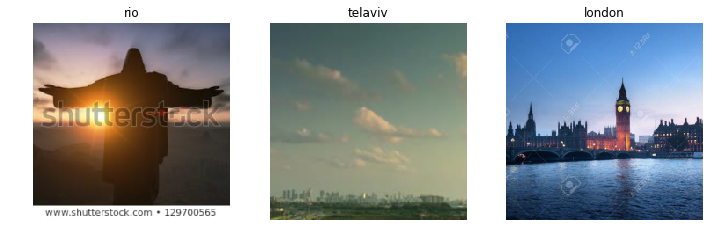

In [20]:
a = HeatMap(m,data, num=3)
a.show_images()

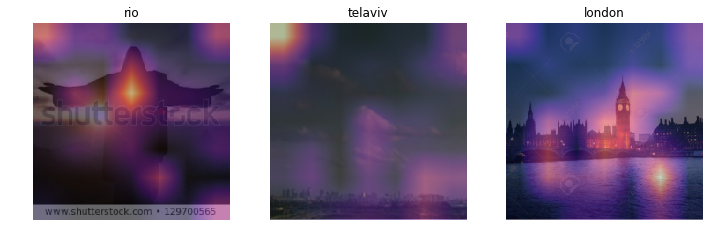

In [21]:
# the level mean witch model part you want. i chose the final one.
a.hooked_backward(level=-1)
a.show_images(heat=True, grad=True)